In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import string
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Data/Toxic Comment Classifier/data.csv') 
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
data.isnull().sum()                       

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
data['toxic'].value_counts()  

0    144277
1     15294
Name: toxic, dtype: int64

In [6]:
data['severe_toxic'].value_counts()  

0    157976
1      1595
Name: severe_toxic, dtype: int64

In [7]:
data['obscene'].value_counts()       

0    151122
1      8449
Name: obscene, dtype: int64

In [8]:
data['threat'].value_counts()            

0    159093
1       478
Name: threat, dtype: int64

In [9]:
data['insult'].value_counts()              

0    151694
1      7877
Name: insult, dtype: int64

In [10]:
data['identity_hate'].value_counts()          

0    158166
1      1405
Name: identity_hate, dtype: int64

### EDA

In [11]:
sentencetype_graph=data.iloc[:,2:].sum()              

In [12]:
sentencetype_graph

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

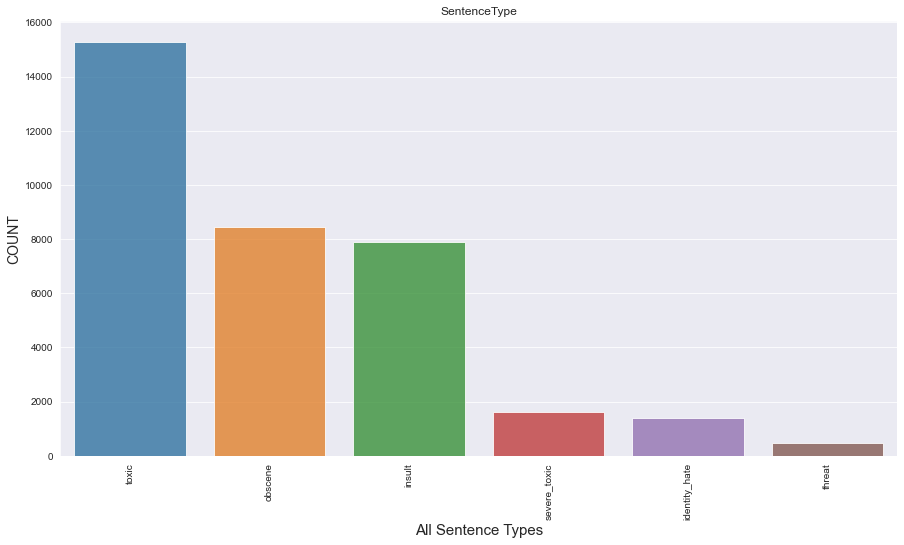

In [13]:
sns.set_style("darkgrid")
ls=sentencetype_graph.sort_values(ascending=False)
plt.figure(figsize=(15,8))
temp =sns.barplot(ls.index, ls.values, alpha=0.8) 
plt.title('SentenceType')
plt.ylabel('COUNT', fontsize=14)
plt.xlabel('All Sentence Types', fontsize=15)
temp.set_xticklabels(rotation=90,labels=ls.index,fontsize=10)
plt.show()

# Text Preprocessing

In [14]:
data['comment_text'][10]

'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

In [15]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [16]:
Insulting_comment_df=data.loc[:,['id','comment_text','insult']]
Insulting_comment_df.head()

,id,comment_text,insult
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [17]:
IdentityHate_comment_df=data.loc[:,['id','comment_text','identity_hate']]
IdentityHate_comment_df.head()

,id,comment_text,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [18]:
Obscene_comment_df=data.loc[:,['id','comment_text','obscene']]
Obscene_comment_df.head()

,id,comment_text,obscene
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [19]:
Threatening_comment_df=data.loc[:,['id','comment_text','threat']]
Threatening_comment_df.head()

,id,comment_text,threat
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [20]:
Severetoxic_comment_df=data.loc[:,['id','comment_text','severe_toxic']]
Severetoxic_comment_df.head()

,id,comment_text,severe_toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [21]:
Toxic_comment_df=data.loc[:,['id','comment_text','toxic']]
Toxic_comment_df.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [22]:
def wordcloud(df, label):
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=2000)
    wc.generate(" ".join(text))
    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)  

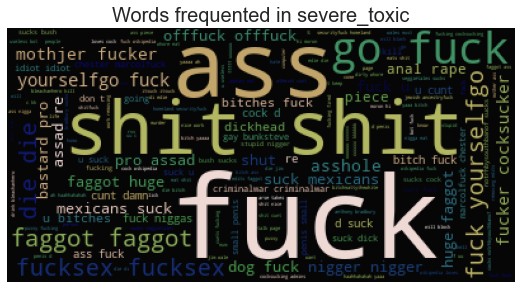

In [23]:
wordcloud(Severetoxic_comment_df,'severe_toxic')

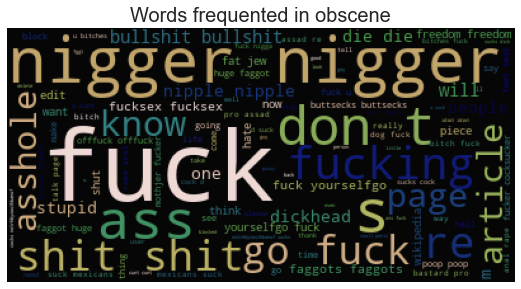

In [24]:
wordcloud(Obscene_comment_df,'obscene')

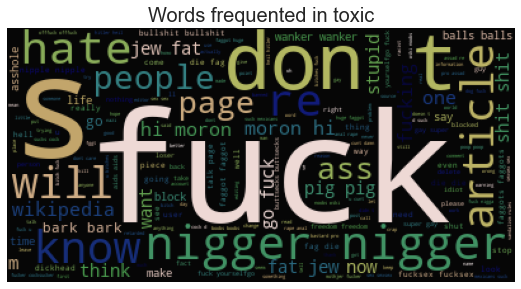

In [25]:
wordcloud(Toxic_comment_df,'toxic')

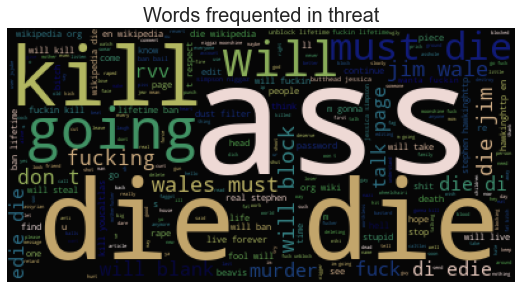

In [26]:
wordcloud(Threatening_comment_df,'threat')

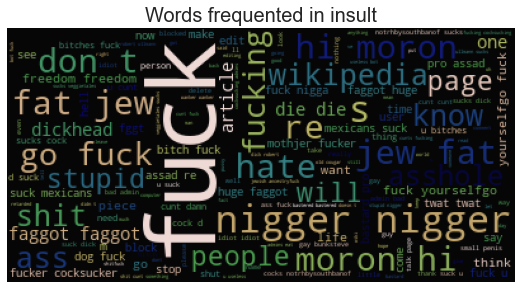

In [27]:
wordcloud(Insulting_comment_df,'insult')

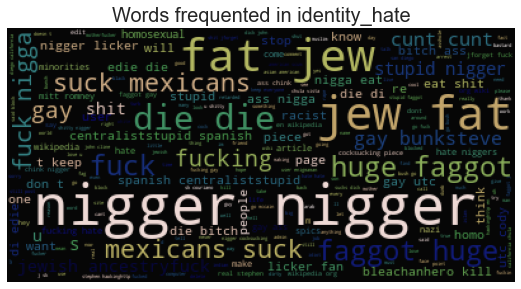

In [28]:
wordcloud(IdentityHate_comment_df,'identity_hate')

## Balancing the target column in the dataset 

In [29]:
Toxic_comment_balanced_1 = Toxic_comment_df[Toxic_comment_df['toxic'] == 1].iloc[0:5000,:]

In [30]:
Toxic_comment_balanced_0 = Toxic_comment_df[Toxic_comment_df['toxic'] == 0].iloc[0:5000,:]

In [31]:
Toxic_comment_balanced_1.shape

(5000, 3)

In [32]:
Toxic_comment_balanced_0.shape

(5000, 3)

In [33]:
Toxic_comment_balanced_1['toxic'].value_counts()

1    5000
Name: toxic, dtype: int64

In [34]:
Toxic_comment_balanced_0['toxic'].value_counts()

0    5000
Name: toxic, dtype: int64

In [35]:
Toxic_comment_balanced=pd.concat([Toxic_comment_balanced_1,Toxic_comment_balanced_0])

In [36]:
Toxic_comment_balanced['toxic'].value_counts()

1    5000
0    5000
Name: toxic, dtype: int64

### Repeating the steps for other subset datasets

In [37]:
Severetoxic_comment_df['severe_toxic'].value_counts()

0    157976
1      1595
Name: severe_toxic, dtype: int64

In [38]:
Severetoxic_comment_df_1 = Severetoxic_comment_df[Severetoxic_comment_df['severe_toxic'] == 1].iloc[0:1595,:]

In [39]:
Severetoxic_comment_df_0 = Severetoxic_comment_df[Severetoxic_comment_df['severe_toxic'] == 0].iloc[0:1595,:]

In [40]:
Severe_toxic_comment_balanced=pd.concat([Severetoxic_comment_df_1,Severetoxic_comment_df_0])

In [41]:
Severe_toxic_comment_balanced['severe_toxic'].value_counts() 

1    1595
0    1595
Name: severe_toxic, dtype: int64

### Repeating the same

In [42]:
Obscene_comment_df['obscene'].value_counts()

0    151122
1      8449
Name: obscene, dtype: int64

In [43]:
Obscene_comment_df_1 = Obscene_comment_df[Obscene_comment_df['obscene'] == 1].iloc[0:5000,:] 

In [44]:
Obscene_comment_df_0 = Obscene_comment_df[Obscene_comment_df['obscene'] == 0].iloc[0:5000,:]

In [45]:
Obscene_comment_balanced = pd.concat([Obscene_comment_df_1,Obscene_comment_df_0])

In [46]:
Obscene_comment_balanced['obscene'].value_counts()

1    5000
0    5000
Name: obscene, dtype: int64

In [47]:
Threatening_comment_df['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [48]:
Threatening_comment_df_1 = Threatening_comment_df[Threatening_comment_df['threat'] == 1].iloc[0:478,:]

In [49]:
Threatening_comment_df_0 = Threatening_comment_df[Threatening_comment_df['threat'] == 0].iloc[0:478,:]

In [50]:
Threatening_comment_balanced = pd.concat([Threatening_comment_df_1,Threatening_comment_df_0])

In [51]:
Threatening_comment_balanced['threat'].value_counts()

1    478
0    478
Name: threat, dtype: int64

In [52]:
Insulting_comment_df['insult'].value_counts()

0    151694
1      7877
Name: insult, dtype: int64

In [53]:
Insulting_comment_df_1 = Insulting_comment_df[Insulting_comment_df['insult'] == 1].iloc[0:5000,:]

In [54]:
Insulting_comment_df_0 = Insulting_comment_df[Insulting_comment_df['insult'] == 0].iloc[0:5000,:]

In [55]:
Insulting_comment_balanced = pd.concat([Insulting_comment_df_1,Insulting_comment_df_0])

In [56]:
Insulting_comment_balanced['insult'].value_counts()

1    5000
0    5000
Name: insult, dtype: int64

In [57]:
IdentityHate_comment_df['identity_hate'].value_counts()

0    158166
1      1405
Name: identity_hate, dtype: int64

In [58]:
IdentityHate_comment_df_1 = IdentityHate_comment_df[IdentityHate_comment_df['identity_hate'] == 1].iloc[0:1405,:]

In [59]:
IdentityHate_comment_df_0 = IdentityHate_comment_df[IdentityHate_comment_df['identity_hate'] == 0].iloc[0:1405,:]

In [60]:
IdentityHate_comment_balanced = pd.concat([IdentityHate_comment_df_1,IdentityHate_comment_df_0])

In [61]:
IdentityHate_comment_balanced['identity_hate'].value_counts()

1    1405
0    1405
Name: identity_hate, dtype: int64

# Model Building

In [62]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import ngrams,bigrams,trigrams

In [63]:
def cv_tf_train_test(dataframe,label,vectorizer,ngram):

    # Split the data into X and y data sets
    X = dataframe.comment_text
    y = dataframe[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

    # Using vectorizer and removing stopwords
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    # Transforming x-train and x-test
    X_train_cv1 = cv1.fit_transform(X_train) 
    X_test_cv1  = cv1.transform(X_test)      
    
    ## Machine learning models   
    
    ## Logistic regression
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    
    ## k-nearest neighbours
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    ## Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    
    ## Multinomial naive bayes
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    
    ## Support vector machine
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    ## Random Forest 
    randomforest = RandomForestClassifier(n_estimators=100, random_state=50)
    randomforest.fit(X_train_cv1, y_train)
    
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
    ## Saving f1 score results into a dataframe                     
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1

### Evaluating model performance using evaluation metrics.

In [64]:
severe_toxic_comment_cv = cv_tf_train_test(Severe_toxic_comment_balanced, 'severe_toxic', TfidfVectorizer, (1,1))
severe_toxic_comment_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)
severe_toxic_comment_cv

,F1 Score(severe_toxic)
Log Regression,0.940282
KNN,0.860192
BernoulliNB,0.790738
MultinomialNB,0.932377
SVM,0.937901
Random Forest,0.941176


In [65]:
obscene_comment_cv = cv_tf_train_test(Obscene_comment_balanced, 'obscene', TfidfVectorizer, (1,1))
obscene_comment_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)
obscene_comment_cv

,F1 Score(obscene)
Log Regression,0.901183
KNN,0.625341
BernoulliNB,0.766640
MultinomialNB,0.887496
SVM,0.915613
Random Forest,0.884261


In [66]:
threat_comment_cv = cv_tf_train_test(Threatening_comment_balanced, 'threat', TfidfVectorizer, (1,1))
threat_comment_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)
threat_comment_cv

,F1 Score(threat)
Log Regression,0.897338
KNN,0.852459
BernoulliNB,0.745205
MultinomialNB,0.902098
SVM,0.894737
Random Forest,0.923077


In [67]:
insult_comment_cv = cv_tf_train_test(Insulting_comment_balanced, 'insult', TfidfVectorizer, (1,1))
insult_comment_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)
insult_comment_cv

,F1 Score(insult)
Log Regression,0.901851
KNN,0.320661
BernoulliNB,0.776986
MultinomialNB,0.896299
SVM,0.906218
Random Forest,0.890821


In [68]:
identity_hatecomment_cv = cv_tf_train_test(IdentityHate_comment_balanced, 'identity_hate', TfidfVectorizer, (1,1))
identity_hatecomment_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)
identity_hatecomment_cv

,F1 Score(identity_hate)
Log Regression,0.905707
KNN,0.820046
BernoulliNB,0.776699
MultinomialNB,0.903302
SVM,0.896806
Random Forest,0.888087


In [69]:
X = Toxic_comment_balanced.comment_text
y = Toxic_comment_balanced['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  
X_test_fit = tfv.transform(X_test)  
randomforest = RandomForestClassifier(n_estimators=100, random_state=50)

randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [70]:
comment1 = ['i killed an insect and ate it']
comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:,1]
## As seen below the above comment is 73 percent toxic

array([0.73519444])

In [71]:
comment2 = ['Is this sentence a good one']
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]
## As seen below the above comment is 0.08 percent toxic which says the comment is not toxic

array([0.08770635])

In [72]:
comment2 = ['truth will prevail']
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]
## The above comment is 46 percent toxic.

array([0.46238997])